In [100]:
# Lots of imports needed
import pandas as pd
#import numpy as np
import geopandas as gpd
import json
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
from bokeh.io import curdoc, output_notebook
from bokeh.models import Slider, HoverTool
from bokeh.layouts import widgetbox, row, column
from bokeh.models.widgets import Dropdown
import matplotlib.pyplot as plt
%matplotlib inline

In [101]:
# Reading the Data, using a specific sheet name. Starting off by skipping the first 5 rows, because that completely messes up the data.
alb_mbd = pd.read_excel("../Data/Nigeria/Nigeria_JRSM_2018_02042020_1580809823.xlsm", sheet_name="ALB_MBD", skiprows=5)
pzq = pd.read_excel("../Data/Nigeria/Nigeria_JRSM_2018_02042020_1580809823.xlsm", sheet_name="PZQ", skiprows=5)
ivm = pd.read_excel("../Data/Nigeria/Nigeria_JRSM_2018_02042020_1580809823.xlsm", sheet_name="IVM", skiprows=5)

In [102]:
## printing the top two rows, as these are the unformated columns. I used this to figure out which columns I needed for the data.
print(alb_mbd.columns)
print(alb_mbd.loc[0])
print(alb_mbd.loc[1])
#ivm.head()
alb_mbd.head()

Index(['Country administrative structure', 'Unnamed: 1', 'Unnamed: 2',
       'Population requiring treatment with ALB/MBD', 'Unnamed: 4',
       'Unnamed: 5', 'Treatment plan', 'Unnamed: 7',
       'People covered by PELF with ALB', 'Loa endemic areas', 'Unnamed: 10',
       'Select medicine for treatment of STH', 'Target population',
       'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16',
       'Unnamed: 17', 'Unnamed: 18', 'Unnamed: 19', 'Albendazole (ALB)',
       'Unnamed: 21', 'Unnamed: 22', 'Unnamed: 23', 'Unnamed: 24',
       'Unnamed: 25', 'Mebendazole (MBD)', 'Unnamed: 27', 'Unnamed: 28'],
      dtype='object')
Country administrative structure                                            Country
Unnamed: 1                                                           Province/State
Unnamed: 2                                                                 District
Population requiring treatment with ALB/MBD                                  PreSAC
Unnamed: 4             

,Country administrative structure,Unnamed: 1,Unnamed: 2,Population requiring treatment with ALB/MBD,Unnamed: 4,Unnamed: 5,Treatment plan,Unnamed: 7,People covered by PELF with ALB,Loa endemic areas,...,Unnamed: 19,Albendazole (ALB),Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Mebendazole (MBD),Unnamed: 27,Unnamed: 28
0,Country,Province/State,District,PreSAC,SAC,Total,LF,STH,NaN,Population,...,NaN,Remaining in stock (LF),Tablets to be procured (LF),Bottle (400 mg)\n200 tablets (LF),Remaining in stock (STH),Tablets to be procured for SAC (STH),Bottle (400 mg)\n200 tablets (STH),Remaining in stock,Tablets to be procured for SAC,Bottles (500 mg)\n150 tablets
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Total,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Nigeria,Abia,Aba North,28912,40477,69389,1,1,115648.0,,...,28912,NaN,115648,579,NaN,0,0,NaN,0,0
3,Nigeria,Abia,Aba South,114007,159609,273616,1,1,456027.0,,...,114007,NaN,456027,2281,NaN,0,0,NaN,0,0
4,Nigeria,Abia,Arochukwu,45782,64094,109876,1,2,183126.0,,...,155658,NaN,183126,916,NaN,0,0,NaN,64094,428


In [103]:
#IVM LF & Oncho
ivm_total_treatment_lf = ivm.iloc[2:, 6]
ivm_total_treatment_oncho = ivm.iloc[2:, 9]
ivm_total_treatment = ivm_total_treatment_lf + ivm_total_treatment_oncho
ivm_total_procured = ivm.iloc[2:, 15] + ivm.iloc[2:, 16]

In [104]:
#Schistosoma
pzq_dist_names = pzq.iloc[2:, 2]
pzq_total_treatment = pzq.iloc[2:, 5]
pzq_tab_procured = pzq.iloc[2:, [16, 17]]
pzq_total_procured = pzq_tab_procured.iloc[:, 0] + pzq_tab_procured.iloc[:, 1]

In [105]:
# Here I selecte the different colummns I  need and store them as seperate Series. The rows start at level 2
# The columns for the first two variables have names, but the rest I find by indexing.
district_names = alb_mbd.loc[2:, "Unnamed: 2"]
total_treatment = alb_mbd.loc[2:, "Unnamed: 5"]
total_target_alb = alb_mbd.iloc[2:, 15]
total_target_mbd = alb_mbd.iloc[2:, 19]
lf_alb_tab_bottle = alb_mbd.iloc[2:, 21:23]
sac_alb_tab_bottle = alb_mbd.iloc[2:, 24:26]
sac_mbd_tab_bottle = alb_mbd.iloc[2:, 27:29]

In [106]:
# Checking to see if the data is actually selected
lf_alb_tab_bottle.head(1)

,Unnamed: 21,Unnamed: 22
2,115648,579


In [107]:
# combining the different Series into one dataframe
selectedData = pd.DataFrame({'district_names':district_names, 'total_treatment_alb_mbd':total_treatment, 'total_target_alb':total_target_alb, 'total_target_mbd':total_target_mbd, 'lf_alb_total_procured':lf_alb_tab_bottle.iloc[:,0] + lf_alb_tab_bottle.iloc[:,1], 'sac_alb_total_procured':sac_alb_tab_bottle.iloc[:,0] + sac_alb_tab_bottle.iloc[:,1], 'sth_mbd_total_procured':sac_mbd_tab_bottle.iloc[:,0] + sac_mbd_tab_bottle.iloc[:,1], 
                            'pzq_total_treatment':pzq_total_treatment, 'pzq_total_procured':pzq_total_procured, 'ivm_total_treatment':ivm_total_treatment, 'ivm_total_procured':ivm_total_procured})

# the data is of type string, so here I am just changing everything but the district names to numerics
for col in selectedData.columns:
    if col != 'district_names':
        selectedData[col] = pd.to_numeric(selectedData[col])

# grouping the data by district names and using a mean to aggregate districts that may have multiple rows
# this is probably not the right way to do it, but it was a quick solution
selectedData = selectedData.groupby('district_names').mean().reset_index()
# saving data
selectedData.to_csv('../Data/Nigeria/filtered_nigeria_data.csv', index=False)
# checking data
selectedData.head(2)

,district_names,total_treatment_alb_mbd,total_target_alb,total_target_mbd,lf_alb_total_procured,sac_alb_total_procured,sth_mbd_total_procured,pzq_total_treatment,pzq_total_procured,ivm_total_treatment,ivm_total_procured
0,AMAC,502601.0,0.0,502601.0,0.0,0.0,295139.0,255489.00,366847.0,110952.934861,311290.217612
1,Aba North,69389.0,0.0,28912.0,116227.0,0.0,0.0,13357.41,0.0,159677.771632,447992.760568


In [108]:
# loading in geojson
shapefile = '../Data/Nigeria/Nigeria_Shape/AFRO_IUs_201812.shp'
gdf = gpd.read_file(shapefile)
nigeria = gdf[gdf.ADMIN0 == 'Nigeria'].copy()
nigeria.head(3)

,CONTINENT,REGION,WHO_REGION,ADMIN0,ADMIN0ID,ADMIN0_FIP,ADMIN0ISO2,ADMIN0ISO3,ADMIN1,ADMIN1ID,...,IU_ID,IUs_NAME,LASTUPDATE,CARTO,IU_ID2,Alt_IU_Nam,Shape_Leng,Shape_Le_1,Shape_Area,geometry
37,Africa,Western Africa,AFRO,Nigeria,34,NI,NG,NGA,Katsina,3795,...,NGA0379536751,Batangarawa,20160308,GEOCONNECT,36751,None,151893.607155,151893.607155,4.668122e+08,"POLYGON ((7.54951 12.71985, 7.54259 12.69966, ..."
38,Africa,Western Africa,AFRO,Nigeria,34,NI,NG,NGA,Katsina,3795,...,NGA0379536752,Batsari,20160308,GEOCONNECT,36752,None,165691.596815,165691.596815,1.132734e+09,"POLYGON ((7.36951 12.90158, 7.36496 12.85866, ..."
39,Africa,Western Africa,AFRO,Nigeria,34,NI,NG,NGA,Katsina,3795,...,NGA0379536753,Baure,20160308,GEOCONNECT,36753,None,122973.886246,122973.886246,7.773444e+08,"POLYGON ((8.97470 12.83391, 8.97479 12.83336, ..."


In [109]:
# merging the two data sets
merged = nigeria.merge(selectedData, left_on='IUs_NAME', right_on='district_names')
# summing up all the requested columns and dividing them by the target population
merged['alb_mbd_ratio'] = (merged['lf_alb_total_procured'] + merged['sac_alb_total_procured'] + merged['sth_mbd_total_procured']) / merged['total_treatment_alb_mbd']
merged['mbd_ratio'] = (merged['sth_mbd_total_procured']) / merged['total_target_mbd']
merged['pzq_ratio'] = merged['pzq_total_procured'] / merged['pzq_total_treatment']
merged['ivm_ratio'] = merged['ivm_total_procured'] / merged['ivm_total_treatment']

In [110]:
merged.loc[(pd.isna(merged.pzq_ratio)), 'pzq_ratio'] = 0
merged.loc[(pd.isna(merged.mbd_ratio)), 'mbd_ratio'] = 0
merged.loc[(pd.isna(merged.alb_mbd_ratio)), 'alb_mbd_ratio'] = 0
merged.loc[(pd.isna(merged.ivm_ratio)), 'ivm_ratio'] = 0
merged.loc[(merged.sth_mbd_total_procured == 0) & (merged.total_target_mbd != 0), 'mbd_ratio'] = None



In [111]:
# checking data
merged[merged.sth_mbd_total_procured != 0].loc[:,['lf_alb_total_procured', 'sac_alb_total_procured', 'sth_mbd_total_procured', 'total_treatment_alb_mbd', 'total_target_mbd', 'mbd_ratio']].head(3) 

,lf_alb_total_procured,sac_alb_total_procured,sth_mbd_total_procured,total_treatment_alb_mbd,total_target_mbd,mbd_ratio
6,0.0,0.0,47652.0,81147.0,81147.0,0.587231
47,150687.0,0.0,52828.0,89962.0,89962.0,0.587226
48,90646.0,0.0,31779.0,54117.0,54117.0,0.587228


In [112]:
#merged.loc[(merged.sth_mbd_total_procured == 0) & (merged.total_target_mbd != 0), ['mbd_ratio']] = merged.total_target_mbd * -1 / 100000
merged.loc[(merged.sth_mbd_total_procured == 0) & (merged.total_target_mbd != 0), ['IUs_NAME', 'alb_mbd_ratio', 'lf_alb_total_procured', 'sth_mbd_total_procured', 'total_target_mbd', 'total_treatment_alb_mbd', 'mbd_ratio']]

,IUs_NAME,alb_mbd_ratio,lf_alb_total_procured,sth_mbd_total_procured,total_target_mbd,total_treatment_alb_mbd,mbd_ratio
26,Bagudo,1.675009,257149.0,0.0,63967.0,153521.0,NaN
29,Dandi,1.675009,156002.0,0.0,38806.0,93135.0,NaN
39,Ukwa West,1.675017,95754.0,0.0,23819.0,57166.0,NaN
40,Umuahia North,1.675002,238599.0,0.0,59353.0,142447.0,NaN
41,Umuahia South,1.675014,149835.0,0.0,37272.0,89453.0,NaN
...,...,...,...,...,...,...,...
724,Ibi,1.675015,90888.0,0.0,22609.0,54261.0,NaN
725,Jalingo,1.675019,151214.0,0.0,37615.0,90276.0,NaN
727,Kurmi,1.674993,98972.0,0.0,24620.0,59088.0,NaN
732,Wukari,1.674995,261182.0,0.0,64971.0,155930.0,NaN


C:\Users\adira\Anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


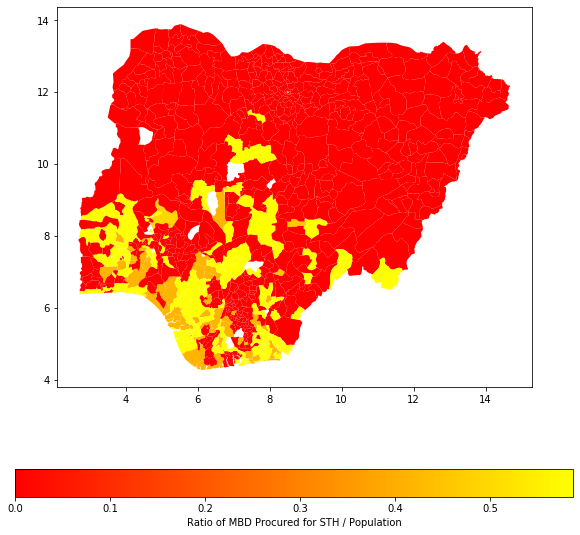

In [113]:
# creating a plot
# any white space is probably a null value, meaning either no data, or something is wrong the data cleaning I did
merged.plot(column='mbd_ratio', legend=True, figsize=(10,10), legend_kwds=
                                    {'label':"Ratio of MBD Procured for STH / Population", 'orientation': "horizontal"}, cmap='autumn')
plt.savefig('nigeria_mbd.svg')

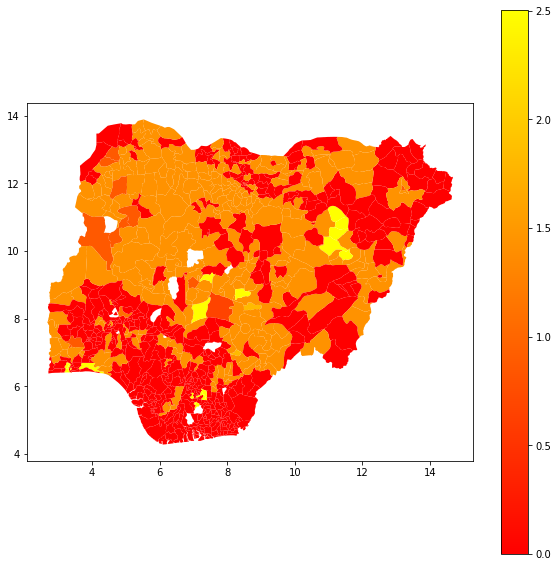

In [114]:
merged.plot(column='pzq_ratio', legend=True, figsize=(10,10), cmap='autumn')
plt.savefig('nigeria_pzq.svg')

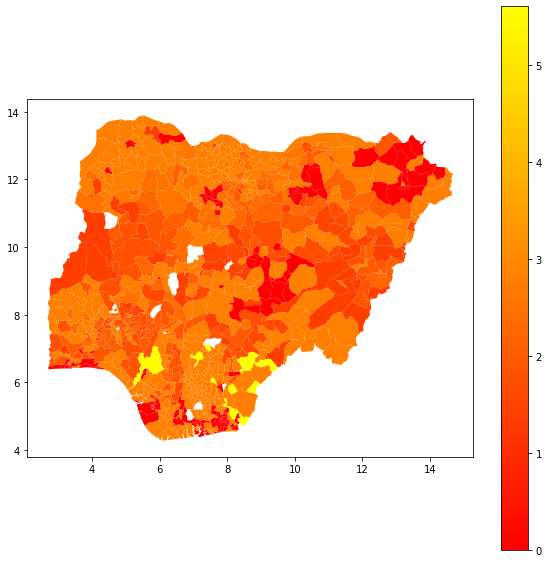

In [115]:
merged.plot(column='ivm_ratio', legend=True, figsize=(10,10), cmap='autumn')

In [87]:
#merged_json = json.loads(merged.to_json())
#json_data = json.dumps(merged_json)

In [119]:
def changeDist(dist):
    if dist == 'all':
        new_data = merged
    else:
        new_data = merged[merged.IUs_NAME == dist]
    merge_json = json.loads(merged.to_json())
    json_d = json.dumps(merged_json)
    return json_d

geosource = GeoJSONDataSource(geojson = changeDist('all'))
palette = brewer['YlGnBu'][8]
palette = palette[::-1]
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 2.5, nan_color='#fa0505')

color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal')

hover = HoverTool(tooltips = [ ('District','@IUs_NAME'),('ratio', '@mbd_ratio')])

p = figure(title = 'Test', plot_height = 600 , plot_width = 950, toolbar_location = None, tools=[hover])
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

p.patches('xs','ys', source = geosource,fill_color = {'field' :'mbd_ratio', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)
p.add_layout(color_bar, 'below')

def update_plot(attr, old, new):
    ctry = slider.value
    new_data = changeDist(ctry)
    geosource.geojson = new_data
    p.title.text = 'MBD Ratio, %d' %ctry
menu = []
for dist_name in merged.IUs_NAME:
    menu.append((dist_name, dist_name))
slider = Slider(title = 'Year',start = 1975, end = 2016, step = 1, value = 2016)
slider.on_change('value', update_plot)
    
dropdown = Dropdown(label="Dropdown button", button_type="warning", menu=menu)
dropdown.on_change('value', update_plot)
layout = column(p,widgetbox(slider))
curdoc().add_root(layout)
#curdoc().add_root(column(dropdown, p))

#output_notebook()
show(layout)
#show(dropdown)

You are generating standalone HTML/JS output, but trying to use real Python
callbacks (i.e. with on_change or on_event). This combination cannot work.

Only JavaScript callbacks may be used with standalone output. For more
information on JavaScript callbacks with Bokeh, see:

    http://bokeh.pydata.org/en/latest/docs/user_guide/interaction/callbacks.html

Alternatively, to use real Python callbacks, a Bokeh server application may
be used. For more information on building and running Bokeh applications, see:

    http://bokeh.pydata.org/en/latest/docs/user_guide/server.html

